# Multiclass semantic segmentation using DeepLabV3+

**Author:** [Soumik Rakshit](http://github.com/soumik12345)<br>
**Date created:** 2021/08/31<br>
**Last modified:** 2023/01/06<br>
**Description:** Implement DeepLabV3+ architecture for Multi-class Semantic Segmentation.

## Downloading the data

We will use the [Crowd Instance-level Human Parsing Dataset](https://arxiv.org/abs/1811.12596)
for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images.
Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification.
This dataset can be used for the "human part segmentation" task.

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import prepareVOC12 as voc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
NUM_CLASSES = 21
DATA_DIR = "./VOC12"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50
single_channel_dict = voc.single_channel_dict

train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "train_label/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "train_label/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

        def apply_rgb_to_single_channel(image_np):
            image_np = voc.rgb_to_single_channel(image_np, single_channel_dict)
            return np.expand_dims(image_np, axis=-1)

        image = tf.py_function(
            func=apply_rgb_to_single_channel,
            inp=[image],
            Tout=tf.float32
        )
        image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 224, 224, 1), dtype=tf.float32, name=None))>


In [3]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [4]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(NUM_CLASSES, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

## Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

Epoch 1/8
250/250 [==============================] - 66s 231ms/step - loss: 1.1395 - accuracy: 0.7562 - val_loss: 1.8916 - val_accuracy: 0.5944
Epoch 2/8
250/250 [==============================] - 57s 227ms/step - loss: 1.0275 - accuracy: 0.7674 - val_loss: 1.1342 - val_accuracy: 0.7348
Epoch 3/8
250/250 [==============================] - 58s 232ms/step - loss: 0.9737 - accuracy: 0.7692 - val_loss: 1.3012 - val_accuracy: 0.6959
Epoch 4/8
250/250 [==============================] - 57s 227ms/step - loss: 0.9385 - accuracy: 0.7701 - val_loss: 1.0805 - val_accuracy: 0.7386
Epoch 5/8
250/250 [==============================] - 56s 223ms/step - loss: 0.8962 - accuracy: 0.7721 - val_loss: 1.1795 - val_accuracy: 0.7228
Epoch 6/8
250/250 [==============================] - 56s 224ms/step - loss: 0.8828 - accuracy: 0.7746 - val_loss: 1.3270 - val_accuracy: 0.7048
Epoch 7/8
250/250 [==============================] - 58s 232ms/step - loss: 0.8394 - accuracy: 0.7779 - val_loss: 1.3404 - val_accuracy:

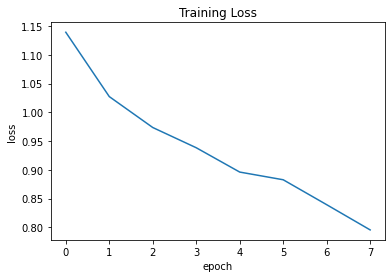

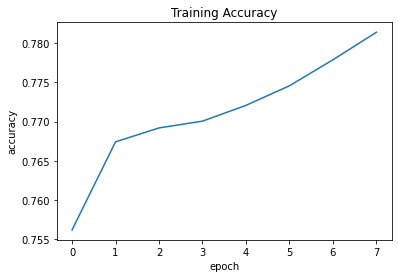

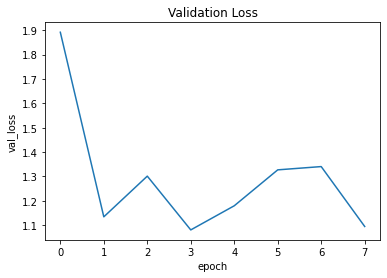

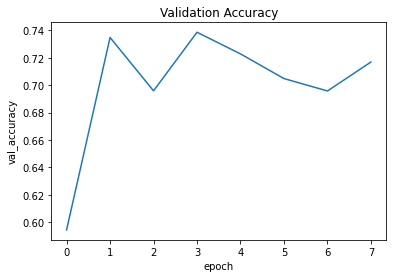

In [5]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=8)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [6]:
# with tf.device('/CPU:0'):
train_predictions = model.predict(train_dataset.take(10), batch_size=4)
print(train_predictions.shape)
# Convert predictions to segmentation masks
train_predictions = np.argmax(train_predictions, axis=-1)
print(train_predictions.shape)

10/10 [==============================] - 2s 94ms/step
(40, 224, 224, 21)
(40, 224, 224)


In [8]:
train_rgb_predicted_masks = [voc.single_channel_to_rgb(predicted_mask, single_channel_dict) for predicted_mask in train_predictions]
train_rgb_predicted_masks = np.array(train_rgb_predicted_masks)
print(train_rgb_predicted_masks.shape)

(40, 224, 224, 3)


Text(0.5, 1.0, 'Converted prediction')

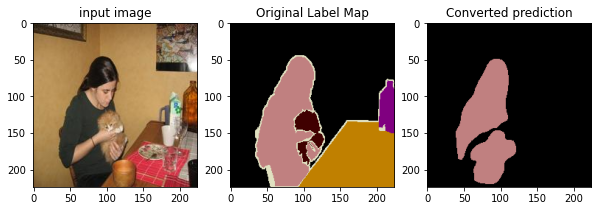

In [49]:
from PIL import Image
index = 35
image = Image.open(train_images[index])
mask = Image.open(train_masks[index])
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('input image')
axs[1].imshow(mask)
axs[1].set_title('Original Label Map')
axs[2].imshow(train_rgb_predicted_masks[index])
axs[2].set_title('Converted prediction')

In [ ]:
# Plot the first 5 masks
for i in range(5):
    plt.imshow(train_rgb_predicted_masks[i])
    plt.show()

In [38]:
# Loading the Colormap
colormap = np.array(list(single_channel_dict.keys()), dtype=np.uint8)
# colormap = colormap * 100
# colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )


### Inference on Train Images

In [ ]:
plot_predictions(train_images[:4], colormap, model=model)

### Inference on Validation Images

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/deeplabv3p-resnet50) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/Human-Part-Segmentation).

In [ ]:
plot_predictions(val_images[:4], colormap, model=model)

In [50]:
def pixel_accuracy_set(y_true_set, y_pred_set):
    num_correct, num_total = 0, 0
    for y_true, y_pred in zip(y_true_set, y_pred_set):
        num_correct += np.sum(y_true == y_pred)
        num_total += y_true.size
    return num_correct / num_total

def mean_accuracy_set(y_true_set, y_pred_set, num_classes):
    class_accuracies = np.zeros(num_classes)
    for y_true, y_pred in zip(y_true_set, y_pred_set):
        for i in range(num_classes):
            mask = y_true == i
            class_accuracies[i] += np.sum((y_pred[mask] == y_true[mask])) / np.sum(mask)
    return np.mean(class_accuracies) / len(y_true_set)

def mean_iou_set(y_true_set, y_pred_set, num_classes):
    class_ious = np.zeros(num_classes)
    for y_true, y_pred in zip(y_true_set, y_pred_set):
        for i in range(num_classes):
            intersection = np.sum((y_true == i) & (y_pred == i))
            union = np.sum((y_true == i) | (y_pred == i))
            class_ious[i] += intersection / union
    return np.mean(class_ious) / len(y_true_set)

def frequency_weighted_iou_set(y_true_set, y_pred_set, num_classes):
    total_pixels = 0
    weighted_iou_sum = 0
    for y_true, y_pred in zip(y_true_set, y_pred_set):
        for i in range(num_classes):
            intersection = np.sum((y_true == i) & (y_pred == i))
            union = np.sum((y_true == i) | (y_pred == i))
            total_pixels += np.sum(y_true == i)
            weighted_iou_sum += (np.sum(y_true == i) * (intersection / union))
    return weighted_iou_sum / total_pixels

In [61]:
print(np.array(train_masks).shape)

(1000,)


In [58]:
y_pred_labels = train_predictions
y_val_labels = []
for i in range(40):
    mask_path = train_masks[i]
    mask = read_image(mask_path, mask=True)
    y_val_labels.append(mask)
y_val_labels = np.array(y_val_labels)
    
pa = pixel_accuracy_set(y_val_labels, y_pred_labels)
ma = mean_accuracy_set(y_val_labels, y_pred_labels, num_classes=21)
miou = mean_iou_set(y_val_labels, y_pred_labels, num_classes=21)
fwiou = frequency_weighted_iou_set(y_val_labels, y_pred_labels, num_classes=21)

print(f"Pixel Accuracy: {pa:.4f}")
print(f"Mean Accuracy: {ma:.4f}")
print(f"Mean IoU: {miou:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed